In [66]:
import os
from pathlib import Path
import sys
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display

In [67]:
dirname = os.path.dirname
ROOT_DIR = dirname(os.path.abspath(''))
sys.path.append(ROOT_DIR)

DATA_DIR = os.path.join(ROOT_DIR, 'data')
AUG_DIR = os.path.join(ROOT_DIR, 'augmented')
AUG_OUT_DIR = os.path.join(AUG_DIR, 'image')
CHECKPOINT_DIR = os.path.join(ROOT_DIR, 'checkpoints')
MODEL_DIR = os.path.join(ROOT_DIR, 'saved_models')

print("ROOT DIR={}".format(ROOT_DIR))
print("DATA DIR={}".format(DATA_DIR))

ROOT DIR=C:\Users\Godonan\Documents\!! Research\Repositories\tsai-gan
DATA DIR=C:\Users\Godonan\Documents\!! Research\Repositories\tsai-gan\data


In [68]:
# Image data information, both must be divisible by 4
HEIGHT = 180
WIDTH = 360
CHANNELS = 1
COLOR_SCHEME = 'grayscale'
if CHANNELS == 3:
    COLOR_SCHEME = 'rgb'
    
# Generator input params
rand_dim = 64  # dimension of generator's input tensor (gaussian noise)

# Training hyperparams
EPOCHS = 100
BATCH_SIZE = 4

# Log params
log_interval = 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
fixed_noise = np.random.normal(size=(BATCH_SIZE, rand_dim))  # fixed noise to generate batches of generated images

In [69]:
def load_images():
    # normalize = lambda x: (x.astype('float32') - 127.5) / 127.5  # normalize to between -1: and 1
    data_gen = ImageDataGenerator()
    return data_gen.flow_from_directory(
        DATA_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        color_mode=COLOR_SCHEME,
        shuffle=True,
        save_to_dir=AUG_OUT_DIR,
        class_mode='categorical'
    )

In [70]:
train_gen = load_images()
train_gen.reset()
train_images = np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

HALF_HEIGHT = int(HEIGHT / 2)
HALF_WIDTH = int(WIDTH / 2)
QUARTER_HEIGHT = int(HEIGHT / 4)
QUARTER_WIDTH = int(WIDTH / 4)

Found 512 images belonging to 1 classes.


In [71]:
def make_generator_model():
    def add_bn_lr(x):
        x.add(layers.BatchNormalization())
        x.add(layers.LeakyReLU())
        return x

    model = tf.keras.Sequential(name='GENERATOR')
    model.add(layers.Dense(QUARTER_HEIGHT * QUARTER_WIDTH * 256, use_bias=False, input_shape=(100,)))
    model = add_bn_lr(model)

    model.add(layers.Reshape((QUARTER_HEIGHT, QUARTER_WIDTH, 256)))
    assert model.output_shape == (None, QUARTER_HEIGHT, QUARTER_WIDTH, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, QUARTER_HEIGHT, QUARTER_WIDTH, 128)
    model = add_bn_lr(model)

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, HALF_HEIGHT, HALF_WIDTH, 64)
    model = add_bn_lr(model)

    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, HEIGHT, WIDTH, CHANNELS)

    return model

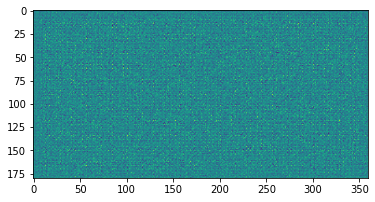

In [72]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [73]:
def make_discriminator_model():
    def add_lr_do(x):
        x.add(layers.LeakyReLU())
        x.add(layers.Dropout(0.3))
        return x

    model = tf.keras.Sequential(name='DISCRIMINATOR')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[HEIGHT, WIDTH, CHANNELS]))
    model = add_lr_do(model)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model = add_lr_do(model)

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [74]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

tf.Tensor([[-0.0005979]], shape=(1, 1), dtype=float32)


In [75]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [76]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [77]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [78]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [79]:
# Print contents of generator and discriminator
generator.summary()
discriminator.summary()

Model: "GENERATOR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1036800)           103680000 
_________________________________________________________________
batch_normalization_9 (Batch (None, 1036800)           4147200   
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1036800)           0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 45, 90, 256)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 45, 90, 128)       819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 45, 90, 128)       512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 45, 90, 128)       0 

In [80]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

In [81]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

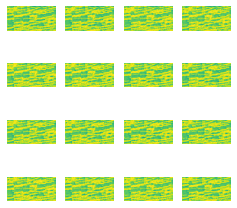

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

In [ ]:
generator.save(os.path.join(MODEL_DIR, 'RecentModel', 'gen_model.h5'))

In [1]:
new_folder = str(datetime.now().strftime("%Y%m%d%H%M%S"))
new_folder = os.path.join(MODEL_DIR, new_folder)
print(new_folder)
os.mkdir(new_folder)
generator.save(os.path.join(MODEL_DIR, new_folder))

NameError: name 'datetime' is not defined